<a href="https://colab.research.google.com/github/chirag2saraiya/TSAI-DeepVision-EVA4/blob/master/07-Variational-AutoEncoders/eva_S7_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

In [ ]:
# Downgrade pytorch and torchvision to get models compatible with aws deployment
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 30kB/s 
     |████████████████████████████████| 6.5MB 46.9MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown https://drive.google.com/uc?id=1dmtT_g31SOT4tnfMLEEXOr9se1xkd0EO

Downloading...
From: https://drive.google.com/uc?id=1dmtT_g31SOT4tnfMLEEXOr9se1xkd0EO
To: /content/cars_data_ready.zip
29.7MB [00:00, 64.1MB/s]


In [ ]:
!unzip -q "cars_data_ready.zip"

In [ ]:
folder = "/content/cars_data"

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
import glob
from PIL import Image
from matplotlib.pyplot import imshow, imsave
#%matplotlib inline
MODEL_NAME = 'VAEncoder'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class CARS(Dataset):
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.png')))
        
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [ ]:

transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor()]
)
dataset = CARS(data_path='/content/cars_data/', transform=transform)

In [ ]:
data_loader = DataLoader(dataset=dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=8)

Parameter Settings
-------------------


MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_channel=1,latent_dims=100):
    super(Encoder, self).__init__()
    self.conv = nn.Sequential(
        # 128 -> 64
        nn.Conv2d(in_channel, 32, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        # 64 -> 32
        nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 32 -> 16
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # 16 -> 8
        nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # 8 -> 4
        nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1)
    )    # we have 128x4x4 dims till now    
    self.fc_mu = nn.Linear(in_features=512, out_features=latent_dims)
    self.fc_logvar = nn.Linear(in_features=512, out_features=latent_dims)
          
  def forward(self, x):
    y_ = self.conv(x)
    y_ = y_.view(y_.size(0), -1)  # y_.size(0) corresponds to the batch size
    y_mu = self.fc_mu(y_)
    y_logvar = self.fc_logvar(y_)
    return y_mu, y_logvar

In [ ]:
from torchsummary import summary
encoder123 = Encoder(in_channel=3,latent_dims=100)
encoder123.to(DEVICE)
summary(encoder123, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,536
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          32,768
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         131,072
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         524,288
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-14            [-1, 51

In [ ]:
class Decoder(nn.Module):
  def __init__(self, out_channel=1, input_size=100,output_size=(128,128,3)):
    super(Decoder, self).__init__()
    assert output_size[0] % 2**5 == 0, 'Should be divided 32' # we want to generate our image in 5 steps as in Descriminator
    self.init_dim = (output_size[0] // 2**5, output_size[1] // 2**5)
    self.fc = nn.Sequential(
        nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),    # 1*100 -> 4*4*128 for default parameters
        nn.ReLU(),
    )   

    self.conv = nn.Sequential(
        #nn.Conv2d(128, 128, 3, padding=1, bias=False),                  # 128x4x4
        #nn.BatchNorm2d(128),
        #nn.ReLU(),
        # x2
        nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),  # 256x8x8
        nn.BatchNorm2d(256),
        nn.ReLU(),            
        # x2
        nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),   # 512x16x16
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # x2
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),   # 256x32x32
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # x2
        nn.ConvTranspose2d(64,32 , 4, stride=2, padding=1, bias=False),   # 128x64x64
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.ConvTranspose2d(32,32 , 4, stride=2, padding=1, bias=False),   # 128x64x64
        nn.BatchNorm2d(32),
        nn.ReLU(),
        
        nn.Conv2d(32, out_channel, 3, padding=1, bias=False), # 3x128x128
        nn.Sigmoid()
    )
  
  def forward(self, x):
    x = x.view(x.size(0), -1)
    y_ = self.fc(x)
    y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
    y_ = self.conv(y_)
    return y_
    

In [ ]:
from torchsummary import summary
decoder123 = Decoder(out_channel=3,input_size=100,output_size=(128,128,3))
decoder123.to(DEVICE)
summary(decoder123, input_size=(1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
              ReLU-2                 [-1, 8192]               0
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 256, 8, 8]             512
              ReLU-5            [-1, 256, 8, 8]               0
   ConvTranspose2d-6          [-1, 128, 16, 16]         524,288
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
   ConvTranspose2d-9           [-1, 64, 32, 32]         131,072
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
  ConvTranspose2d-12           [-1, 32, 64, 64]          32,768
      BatchNorm2d-13           [-1, 32, 64, 64]              64
             ReLU-14           [-1, 32,

In [ ]:

class VariationalAutoencoder(nn.Module):
    def __init__(self,in_channel=3,latent_dims=100,out_channel=3,output_size=(128,128,3)):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(in_channel=in_channel,latent_dims=latent_dims)
        self.decoder = Decoder(out_channel=out_channel,input_size=latent_dims,output_size=output_size)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
  
    def latent_sample(self, mu, logvar):
        # the reparameterization trick
        std = logvar.mul(0.5).exp_()
        eps = torch.empty_like(std).normal_()
        return eps.mul(std).add_(mu)
 
    

In [ ]:
def vae_loss(recon_x, x, mu, logvar,image_size=(64,64,3)):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    criterion = nn.MSELoss()
    recon_loss = criterion(recon_x,x)
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print('reconLoss: ',recon_loss.item(),' klD: ',kldivergence.item())
    kldivergence/=((64.0))
    #print('reconLoss: ',recon_loss.item(),' klD: ',kldivergence.item())
    return recon_loss + variational_beta * kldivergence
    

In [ ]:
from torchsummary import summary
vae123 = VariationalAutoencoder(in_channel=3,latent_dims=100,out_channel=3,output_size=(128,128,3))
vae123.to(DEVICE)
summary(vae123, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,536
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          32,768
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         131,072
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         524,288
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-14            [-1, 51

In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 100
num_epochs = 1000
batch_size = 64
learning_rate = 1e-2
variational_beta = 0.01
use_gpu = True


In [ ]:

vae = VariationalAutoencoder(in_channel=3,latent_dims=100,out_channel=3,output_size=(128,128,3))
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 6522344


Train VAE
--------

In [ ]:
test_batch = next(iter(data_loader))
test_batch = test_batch.to(device)
test_batch_recon, latent_mu, latent_logvar = vae(test_batch)
loss = vae_loss(test_batch_recon, test_batch, latent_mu, latent_logvar)
print(loss.item())

0.07060439884662628


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

def visualise_output(data_loader, model,device, orig_fname,reco_fname):
  images = iter(data_loader).next()
  orig_imagegrid = torchvision.utils.make_grid(images[:9],3,3)
  np_orig_imagegrid = orig_imagegrid.detach().cpu().numpy().transpose(1,2,0)
  plt.figure()
  plt.axis('off')
  plt.imshow(np_orig_imagegrid)
  plt.savefig(orig_fname)

  with torch.no_grad():
    images = images.to(device)
    images, _, _ = model(images)
    reco_imagegrid = torchvision.utils.make_grid(images[:9],3,3)
    np_reco_imagegrid = reco_imagegrid.detach().cpu().numpy().transpose(1,2,0)
    plt.figure()
    plt.axis('off')
    plt.imshow(np_reco_imagegrid)
    plt.savefig(reco_fname)
    
# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(data_loader, vae,device,'test_orig.jpg','test_reco.jpg')

In [ ]:
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5,betas=(0.5, 0.999))
reduceLrOnPlateau_sched = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor =0.9,patience = 20,verbose=True,threshold=0.001 )
# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in data_loader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1

    if(epoch % 30 == 0):
      orig_image_name = f'/content/drive/My Drive/e4p2_vae/images/orig_epoch_{epoch}.jpg'
      reco_image_name = f'/content/drive/My Drive/e4p2_vae/images/reco_epoch_{epoch}.jpg'
      visualise_output(data_loader, vae,device,orig_image_name,reco_image_name)

      model_fname = f'/content/drive/My Drive/e4p2_vae/models/model_epoch_{epoch}.pth'
      torch.save(vae,model_fname)
    train_loss_avg[-1] /= num_batches
    reduceLrOnPlateau_sched.step(train_loss_avg[-1])
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 1000] average reconstruction error: 0.509321


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VariationalAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [2 / 1000] average reconstruction error: 0.078329
Epoch [3 / 1000] average reconstruction error: 0.072752
Epoch [4 / 1000] average reconstruction error: 0.070886
Epoch [5 / 1000] average reconstruction error: 0.072412
Epoch [6 / 1000] average reconstruction error: 0.069225
Epoch [7 / 1000] average reconstruction error: 0.071980
Epoch [8 / 1000] average reconstruction error: 0.069085
Epoch [9 / 1000] average reconstruction error: 0.070079
Epoch [10 / 1000] average reconstruction error: 0.068509
Epoch [11 / 1000] average reconstruction error: 0.068884
Epoch [12 / 1000] average reconstruction error: 0.069440
Epoch [13 / 1000] average reconstruction error: 0.067817
Epoch [14 / 1000] average reconstruction error: 0.068616
Epoch [15 / 1000] average reconstruction error: 0.068761
Epoch [16 / 1000] average reconstruction error: 0.068374
Epoch [17 / 1000] average reconstruction error: 0.066985
Epoch [18 / 1000] average reconstruction error: 0.069411
Epoch [19 / 1000] average reconstructio

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch [301 / 1000] average reconstruction error: 0.065014
Epoch [302 / 1000] average reconstruction error: 0.064933
Epoch [303 / 1000] average reconstruction error: 0.065366
Epoch [304 / 1000] average reconstruction error: 0.065405
Epoch [305 / 1000] average reconstruction error: 0.065177
Epoch [306 / 1000] average reconstruction error: 0.064900
Epoch [307 / 1000] average reconstruction error: 0.065132
Epoch [308 / 1000] average reconstruction error: 0.064928
Epoch [309 / 1000] average reconstruction error: 0.064949
Epoch [310 / 1000] average reconstruction error: 0.064938
Epoch [311 / 1000] average reconstruction error: 0.065754
Epoch   312: reducing learning rate of group 0 to 3.4868e-03.
Epoch [312 / 1000] average reconstruction error: 0.065437
Epoch [313 / 1000] average reconstruction error: 0.065004
Epoch [314 / 1000] average reconstruction error: 0.065363
Epoch [315 / 1000] average reconstruction error: 0.064661
Epoch [316 / 1000] average reconstruction error: 0.064489
Epoch [317

Plot Training Curve
--------------------

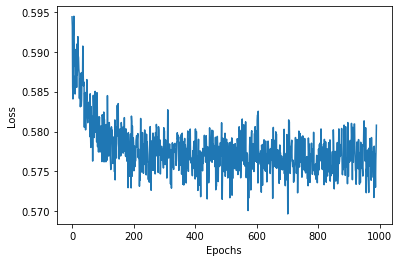

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg[10:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Original images


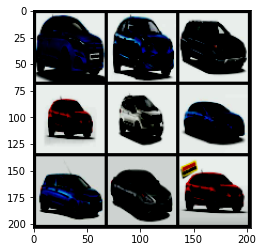

VAE reconstruction:


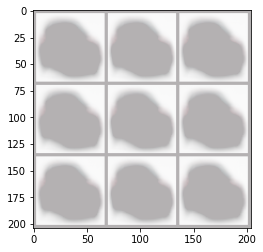

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()
def 
def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        #images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[:9], 3, 3).numpy()
        channel_stdevs = (0.3204, 0.3266, 0.3235)
        channel_means = (0.7067, 0.6947, 0.7008)
        for i in range(np_imagegrid.shape[0]):
          np_imagegrid[i,:,:] = (np_imagegrid[i,:,:]*channel_stdevs[i]) + channel_means[i]
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images = iter(data_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[:9],3,3))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

In [ ]:
np_imagegrid = torchvision.utils.make_grid(img_batch[:2], 1, 2).numpy()
np_imagegrid.shape

(3, 134, 68)

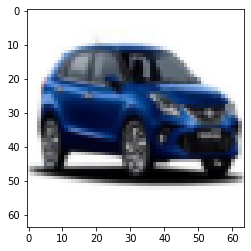

In [ ]:
import matplotlib.pyplot as plt
channel_stdevs = (0.3204, 0.3266, 0.3235)
channel_means = (0.7067, 0.6947, 0.7008)
plt.imshow(un_normalize_to_np(img_batch[6],channel_means,channel_stdevs))
#plt.show()

In [ ]:
img_batch = next(iter(data_loader))

In [ ]:
img_np = img_batch[0].cpu().numpy().transpose(1,2,0)
channel_stdevs = (0.3204, 0.3266, 0.3235)
channel_means = (0.7067, 0.6947, 0.7008)
for i in range(img_np.shape[2]):
    img_np[i] = (img_np[i]*channel_stdevs[i]) + channel_means[i]

plt.imshow(img_np)
plt.show()

NameError: ignored

In [ ]:
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19294.807126


Visualize Reconstructions
--------------------------

Original images


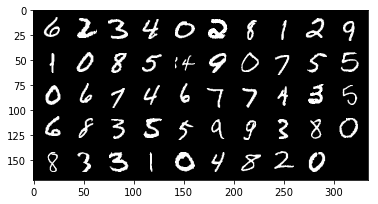

VAE reconstruction:


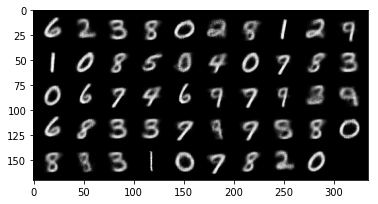

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

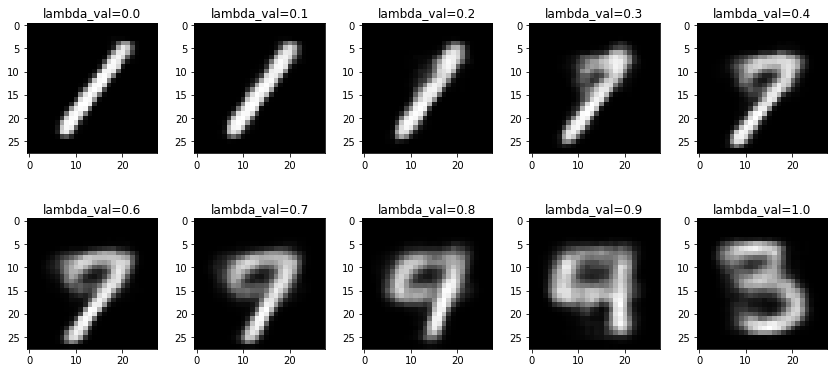

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

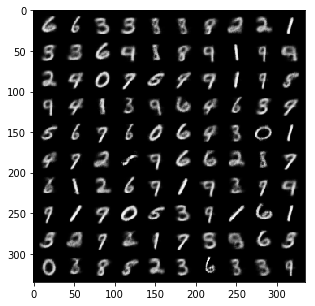

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

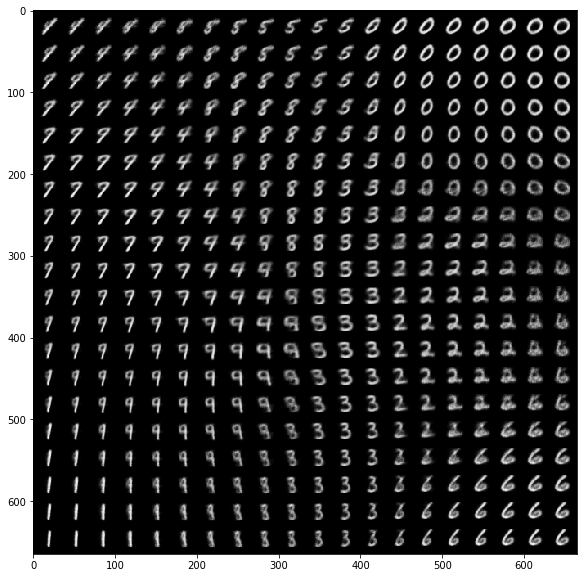

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()